In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc
from IPython.core.display import display, HTML, display_pretty
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from imblearn.datasets import make_imbalance
os.chdir('/home/sambeet/data/dsg/')

In [137]:
trade = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade['BuySell'] = trade['BuySell'].astype('category')
trade['TradeStatus'] = trade['TradeStatus'].astype('category')
trade['CustomerInterest'] = trade['CustomerInterest'].astype('bool')
trade['year'] = trade.TradeDateKey.dt.year
trade['month'] = trade.TradeDateKey.dt.month
trade['weekofyear'] = trade.TradeDateKey.dt.weekofyear
trade = trade.groupby(['CustomerIdx','IsinIdx','BuySell','year','month','weekofyear'])['CustomerInterest'].sum().reset_index()
trade['CustomerInterest'] = trade.CustomerInterest >= 1
#marketdata = pd.read_csv('Market.csv',parse_dates=['DateKey'])
#macromarketdata = pd.read_csv('MarketData_Macro.csv',parse_dates=['DateKey'])
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)
trade = trade.merge(customer,on=['CustomerIdx'],how='left')
bond = bond.rename({'Region':'BondRegion'},axis=1)
trade = trade.merge(bond,on=['IsinIdx'],how='left')
#trade['days_issued'] = (trade['TradeDateKey'] - trade['IssueDateKey']).dt.days
#trade['days_maturity'] = (trade['ActualMaturityDateKey'] - trade['TradeDateKey']).dt.days
#test_submit['days_issued'] = (test_submit['TradeDateKey'] - test_submit['IssueDateKey']).dt.days
#test_submit['days_maturity'] = (test_submit['ActualMaturityDateKey'] - test_submit['TradeDateKey']).dt.days
del customer, bond
gc.collect()
categorical_to_be_transformed = ['BuySell','Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade[feature].astype(str))    
    trade[feature] = encoder.transform(trade[feature].astype(str))
#   test_submit[feature] = encoder.transform(test_submit[feature].astype(str))

Transforming BuySell...
Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


In [138]:
trade.head()

,CustomerIdx,IsinIdx,BuySell,year,month,weekofyear,CustomerInterest,Sector,Subsector,CustomerRegion,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,0,16471,0,2017,5,20,True,0,24,1,...,1,2,1,0,11,7,247,5,5.500000e+08,0
1,0,16499,0,2017,6,23,True,0,24,1,...,1,2,1,0,9,7,247,5,1.500000e+09,0
2,0,20601,0,2017,6,24,True,0,24,1,...,1,2,1,0,7,7,247,5,2.500000e+08,0
3,0,20737,0,2017,6,26,True,0,24,1,...,1,2,1,0,28,7,247,5,5.000000e+08,4
4,0,20909,1,2016,11,45,True,0,24,1,...,1,2,1,0,28,9,81,5,4.000000e+08,0


In [139]:
categorical_holdings = categorical_to_be_transformed + ['year','CustomerIdx','IsinIdx','weekofyear']
#categorical.remove('BuySell')
predictors_holdings = list(trade.columns)
#predictors.remove('TradeDateKey')
#predictors.remove('IsinIdx')
#predictors.remove('Price')
predictors_holdings.remove('CustomerInterest')
#predictors.remove('BuySell')
predictors_holdings.remove('ActualMaturityDateKey')
predictors_holdings.remove('IssueDateKey')
#predictors.remove('TradeStatus')
#predictors.remove('NotionalEUR')
#predictors.remove('BondPrice')
#predictors.remove('Yield')
#predictors.remove('ZSpread')
#predictors.remove('day')
#predictors.remove('weekday')
predictors_holdings.remove('TickerIdx')
#predictors_holdings.remove('weekofyear')
#predictors_holdings.remove('month')
#predictors.remove('CustomerIdx')

target_holdings = 'CustomerInterest'
print(predictors_holdings,categorical_holdings,len(predictors_holdings),trade.shape[0])

(['CustomerIdx', 'IsinIdx', 'BuySell', 'year', 'month', 'weekofyear', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'IssuedAmount', 'CouponType'], ['BuySell', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType', 'year', 'CustomerIdx', 'IsinIdx', 'weekofyear'], 23, 6280924)


categorical = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
predictors = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
target = 'BuySell'
print(predictors,categorical,len(predictors),trade.shape[0],test.shape[0])

In [140]:
#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int),
#                                                                         1:np.sum(trade.CustomerInterest == 1)},random_state=37)

#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.sum(trade.CustomerInterest == 0),
#                                                                         1:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int)},random_state=37)
trade = trade.sort_values(['year','month','weekofyear']).reset_index(drop=True)
valid_index = list(trade[(trade.year == 2018) & (trade.weekofyear >= 13)].index)
all_index = list(trade.index)
train_index = list(set(all_index) - set(valid_index))
len(all_index) - len(train_index) - len(valid_index)
x_train = trade.loc[train_index,predictors_holdings].values
y_train = trade.loc[train_index,target_holdings].values
x_valid = trade.loc[valid_index,predictors_holdings].values
y_valid = trade.loc[valid_index,target_holdings].values
#train_index, valid_index = train_test_split(np.arange(trade_undersampled.shape[0]), test_size=0.2, random_state=37)
#train_index = range(3494374)
#valid_index = range(3494374,3729982) + range(3786265,3920366) + range(6536514,6682124)
#trade_undersampled.shape

In [141]:
rounds = 10000
early_stop_rounds = 50

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 10,
#    'max_depth': 3,
    'learning_rate' : 0.1,
#    'feature_fraction' : 1,
#    'bagging_fraction' : 0.6,
#    'bagging_freq' : 5,
    'verbosity' : 1,
    'num_threads' : 8,
#    'min_data_in_leaf' : 10000,
#    'lambda_l1' : 1,
#    'lambda_l2' : 1,
#    'cat_smooth' : 50,
#    'max_bin' : 50,
    'scale_pos_weight' : 0.001
}

In [142]:
# LGBM Dataset Formatting 
train = lgb.Dataset(x_train,y_train,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
valid = lgb.Dataset(x_valid,y_valid,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
model_holdings = lgb.train(lgbm_params,train,num_boost_round=rounds,valid_sets=[train,valid],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=50)
#del x_valid ; x_train; gc.collect()

Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.912803	valid's auc: 0.890184
[100]	train's auc: 0.98006	valid's auc: 0.954394
[150]	train's auc: 0.984759	valid's auc: 0.956349
Early stopping, best iteration is:
[118]	train's auc: 0.982849	valid's auc: 0.958559


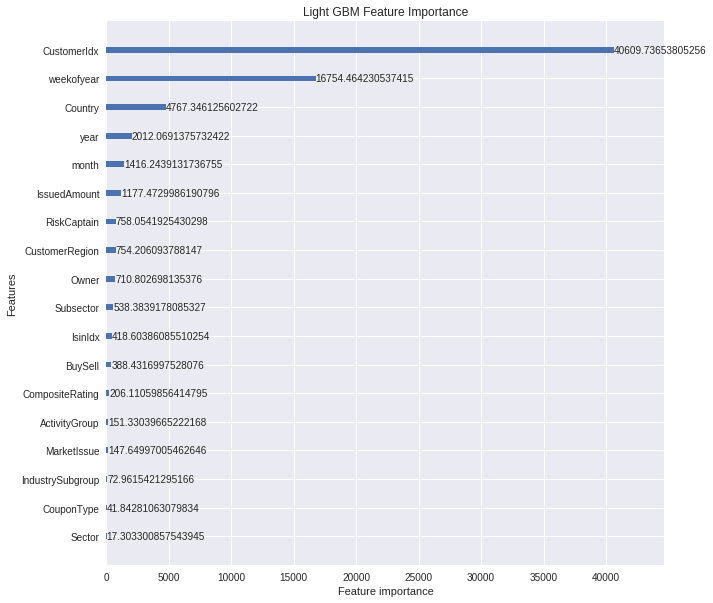

In [143]:
lgb.plot_importance(model_holdings,importance_type='gain',figsize=(10,10))
plt.title("Light GBM Feature Importance")

In [22]:
trade = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade['BuySell'] = trade['BuySell'].astype('category')
trade['TradeStatus'] = trade['TradeStatus'].astype('category')
trade['CustomerInterest'] = trade['CustomerInterest'].astype('bool')
trade['year'] = trade.TradeDateKey.dt.year
trade['month'] = trade.TradeDateKey.dt.month
trade['weekofyear'] = trade.TradeDateKey.dt.weekofyear

In [23]:
trade.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest,year,month,weekofyear
0,2016-12-07,2789,8478,Sell,653168.0,0.0,Unknown,True,2016,12,49
1,2017-03-29,2574,14562,Buy,1656487.0,0.0,Unknown,True,2017,3,13
2,2017-04-18,2574,4747,Buy,939673.0,0.0,Unknown,True,2017,4,16
3,2017-03-10,2574,9885,Sell,708082.0,0.0,Unknown,True,2017,3,10
4,2016-11-16,2574,8885,Buy,1147709.0,0.0,Unknown,True,2016,11,46


In [24]:
trade = trade[trade.CustomerInterest == 1].groupby(['CustomerIdx','IsinIdx','BuySell','year','month','weekofyear'])['CustomerInterest'].sum().reset_index()

In [25]:
trade['CustomerInterest'] = trade.CustomerInterest >= 1

trade['BuySell'] = trade['BuySell'].astype('category')
encoder = LabelEncoder()
encoder.fit(trade['BuySell'].astype(str))    
trade['BuySell'] = encoder.transform(trade['BuySell'].astype(str))

encoder.transform(['Buy','Sell'])

In [6]:
trade.shape

(1783648, 7)

In [26]:
#marketdata = pd.read_csv('Market.csv',parse_dates=['DateKey'])
#macromarketdata = pd.read_csv('MarketData_Macro.csv',parse_dates=['DateKey'])
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)
trade = trade.merge(customer,on=['CustomerIdx'],how='left')
bond = bond.rename({'Region':'BondRegion'},axis=1)
trade = trade.merge(bond,on=['IsinIdx'],how='left')
#trade['days_issued'] = (trade['TradeDateKey'] - trade['IssueDateKey']).dt.days
#trade['days_maturity'] = (trade['ActualMaturityDateKey'] - trade['TradeDateKey']).dt.days
test_submit = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test_submit = test_submit.rename({'DateKey':'TradeDateKey'},axis=1)
test_submit['BuySell'] = test_submit['BuySell'].astype('category')
test_submit['TradeDateKey'] = '20180423'
test_submit['TradeDateKey'] = pd.to_datetime(test_submit.TradeDateKey)
test_submit['year'] = test_submit.TradeDateKey.dt.year
test_submit['month'] = test_submit.TradeDateKey.dt.month
test_submit['weekofyear'] = test_submit.TradeDateKey.dt.weekofyear
test_submit = test_submit.merge(customer,on=['CustomerIdx'],how='left')
test_submit = test_submit.merge(bond,on=['IsinIdx'],how='left')
#test_submit['days_issued'] = (test_submit['TradeDateKey'] - test_submit['IssueDateKey']).dt.days
#test_submit['days_maturity'] = (test_submit['ActualMaturityDateKey'] - test_submit['TradeDateKey']).dt.days
del customer, bond
gc.collect()
categorical_to_be_transformed = ['BuySell','Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade[feature].append(test_submit[feature]).astype(str))    
    trade[feature] = encoder.transform(trade[feature].astype(str))
    test_submit[feature] = encoder.transform(test_submit[feature].astype(str))

Transforming BuySell...
Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


In [27]:
test_submit.head()

,PredictionIdx,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,month,weekofyear,Sector,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,a1e0d80784,2018-04-23,1856,13323,0,NaN,2018,4,17,0,...,0,3,4,96,9,4,224,7,4.500000e+08,0
1,c2cc6cc2a8,2018-04-23,1856,9230,0,NaN,2018,4,17,0,...,0,3,4,87,7,7,193,10,4.000000e+08,0
2,a8e94f6344,2018-04-23,1780,9157,0,NaN,2018,4,17,0,...,0,7,22,83,1,9,81,2,3.000000e+08,1
3,758bae1e35,2018-04-23,2129,9131,0,NaN,2018,4,17,1,...,0,7,22,83,1,9,81,7,4.000000e+09,0
4,02ab378ee8,2018-04-23,1758,7151,0,NaN,2018,4,17,0,...,0,7,24,79,14,12,91,10,3.000000e+08,0


trade['wom'] = trade['TradeDateKey'].apply(lambda d: (d.day-1) // 7 + 1)
test['wom'] = test['TradeDateKey'].apply(lambda d: (d.day-1) // 7 + 1)

In [8]:
categorical = categorical_to_be_transformed + ['year','CustomerIdx','IsinIdx','TickerIdx']#,'month']#,'weekofyear']#,'quarter']
categorical.remove('BuySell')
predictors = list(trade.columns)
#predictors.remove('TradeDateKey')
#predictors.remove('IsinIdx')
#predictors.remove('Price')
predictors.remove('CustomerInterest')
predictors.remove('BuySell')
predictors.remove('ActualMaturityDateKey')
predictors.remove('IssueDateKey')
#predictors.remove('TradeStatus')
#predictors.remove('NotionalEUR')
#predictors.remove('BondPrice')
#predictors.remove('Yield')
#predictors.remove('ZSpread')
#predictors.remove('day')
#predictors.remove('weekday')
#predictors.remove('TickerIdx')
predictors.remove('weekofyear')
predictors.remove('month')
#predictors.remove('CustomerIdx')

target = 'BuySell'
print(predictors,categorical,len(predictors),trade.shape[0],test_submit.shape[0])

(['CustomerIdx', 'IsinIdx', 'year', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'IssuedAmount', 'CouponType'], ['Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType', 'year', 'CustomerIdx', 'IsinIdx', 'TickerIdx'], 21, 1783648, 484758)


categorical = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
predictors = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
target = 'BuySell'
print(predictors,categorical,len(predictors),trade.shape[0],test.shape[0])

In [9]:
#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int),
#                                                                         1:np.sum(trade.CustomerInterest == 1)},random_state=37)

#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.sum(trade.CustomerInterest == 0),
#                                                                         1:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int)},random_state=37)
trade = trade.sort_values(['year','month','weekofyear']).reset_index(drop=True)
valid_index = list(trade[(trade.year == 2018) & (trade.weekofyear >= 13)].index)
all_index = list(trade.index)
train_index = list(set(all_index) - set(valid_index))
len(all_index) - len(train_index) - len(valid_index)
x_train = trade.loc[train_index,predictors].values
y_train = trade.loc[train_index,target].values
x_valid = trade.loc[valid_index,predictors].values
y_valid = trade.loc[valid_index,target].values
#train_index, valid_index = train_test_split(np.arange(trade_undersampled.shape[0]), test_size=0.2, random_state=37)
#train_index = range(3494374)
#valid_index = range(3494374,3729982) + range(3786265,3920366) + range(6536514,6682124)
#trade_undersampled.shape

In [10]:
rounds = 10000
early_stop_rounds = 50

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 10,
#    'max_depth': 3,
    'learning_rate' : 0.1,
#    'feature_fraction' : 0.5,
#    'bagging_fraction' : 0.6,
#    'bagging_freq' : 5,
    'verbosity' : 1,
    'num_threads' : 8,
#    'min_data_in_leaf' : 10000,
#    'lambda_l1' : 1,
#    'lambda_l2' : 1,
#    'cat_smooth' : 50,
#    'max_bin' : 50,
#    'scale_pos_weight' : 3
}

In [11]:
# LGBM Dataset Formatting 
train = lgb.Dataset(x_train,y_train,feature_name=predictors,categorical_feature = categorical)
valid = lgb.Dataset(x_valid,y_valid,feature_name=predictors,categorical_feature = categorical)
model = lgb.train(lgbm_params,train,num_boost_round=rounds,valid_sets=[train,valid],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=50)
#del x_valid ; x_train; gc.collect()

/home/sambeet/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/sambeet/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.64694	valid's auc: 0.621809
[100]	train's auc: 0.662522	valid's auc: 0.629321
[150]	train's auc: 0.670737	valid's auc: 0.632819
[200]	train's auc: 0.676982	valid's auc: 0.635247
[250]	train's auc: 0.682797	valid's auc: 0.638066
[300]	train's auc: 0.686767	valid's auc: 0.639275
[350]	train's auc: 0.691217	valid's auc: 0.640562
[400]	train's auc: 0.695037	valid's auc: 0.64183
[450]	train's auc: 0.698399	valid's auc: 0.642734
[500]	train's auc: 0.702131	valid's auc: 0.643928
[550]	train's auc: 0.704746	valid's auc: 0.644362
[600]	train's auc: 0.706853	valid's auc: 0.644764
[650]	train's auc: 0.708965	valid's auc: 0.644993
[700]	train's auc: 0.710644	valid's auc: 0.645333
[750]	train's auc: 0.712804	valid's auc: 0.64602
[800]	train's auc: 0.714638	valid's auc: 0.646574
[850]	train's auc: 0.71616	valid's auc: 0.646904
[900]	train's auc: 0.718196	valid's auc: 0.647271
[950]	train's auc: 0.720253	valid's auc: 0.

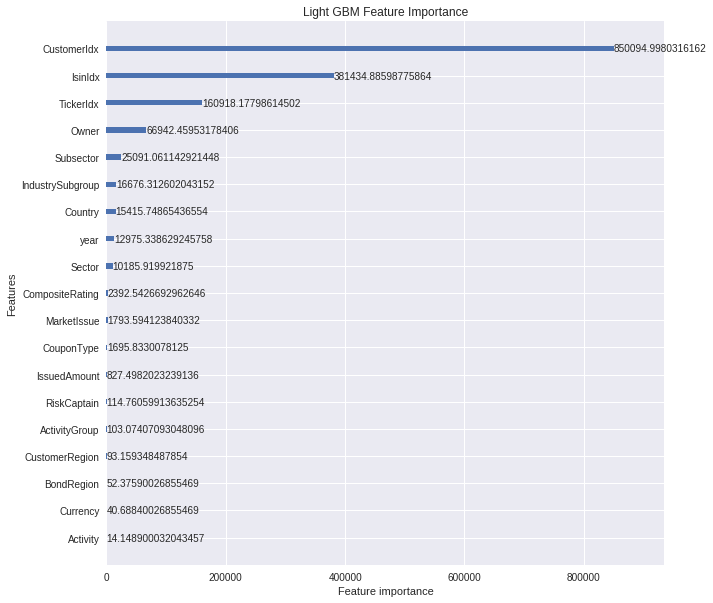

In [12]:
lgb.plot_importance(model,importance_type='gain',figsize=(10,10))
plt.title("Light GBM Feature Importance")

x = test[test.BuySell == 'Sell']['CustomerInterest']#.describe()
sns.distplot(x)

import catboost as cb
cat_features_index = [0,1]

'''
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
cb_model.fit(train, y_train)
'''
#With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=255,depth=3, iterations= 100, l2_leaf_reg= 9, learning_rate= 0.01)
clf.fit(trade.loc[train_index,predictors],trade.loc[train_index,target], cat_features= cat_features_index,
       eval_set=(trade.loc[valid_index,predictors],trade.loc[valid_index,target]),plot=True)

In [155]:
#Create valid
filtered = trade[(trade.year == 2018) & (trade.weekofyear >= 13) & (trade.CustomerInterest == True)].reset_index(drop=True)
filtered = filtered.drop_duplicates()
#filtered = filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear']]
filtered_sell = filtered[['CustomerIdx','IsinIdx']].drop_duplicates()
filtered_buy = filtered_sell.copy()
filtered_sell['BuySell'] = 1
filtered_buy['BuySell'] = 0
filtered_valid_1 = pd.concat([filtered_sell,filtered_buy],axis=0)
filtered_valid_1['year'] = 2018
filtered_valid_1['weekofyear'] = 13
filtered_valid_2 = filtered_valid_1.copy()
filtered_valid_2['weekofyear'] = 14
filtered_valid_3 = filtered_valid_1.copy()
filtered_valid_3['weekofyear'] = 15
filtered_valid_4 = filtered_valid_1.copy()
filtered_valid_4['weekofyear'] = 16
filtered_valid = pd.concat([filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4],axis=0)
del filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4,filtered_buy,filtered_sell
gc.collect()
filtered_valid = filtered_valid.merge(filtered,on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
filtered_valid['CustomerInterest'][filtered_valid.CustomerInterest.isnull()] = 0
filtered_valid.head()

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,CustomerIdx,IsinIdx,BuySell,year,weekofyear,month,CustomerInterest,Sector,Subsector,CustomerRegion,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,2,5215,1,2018,13,3.0,True,0.0,23.0,0.0,...,0.0,0.0,0.0,17.0,7.0,8.0,293.0,7.0,3.245605e+09,0.0
1,2,16812,1,2018,13,3.0,True,0.0,23.0,0.0,...,0.0,12.0,14.0,22.0,10.0,4.0,7.0,5.0,5.000000e+08,0.0
2,2,17091,1,2018,13,3.0,True,0.0,23.0,0.0,...,0.0,12.0,11.0,18.0,12.0,7.0,295.0,5.0,1.000000e+09,0.0
3,2,17275,1,2018,13,3.0,True,0.0,23.0,0.0,...,0.0,12.0,11.0,18.0,7.0,7.0,48.0,3.0,7.500000e+08,4.0
4,14,15545,1,2018,13,3.0,True,0.0,23.0,2.0,...,0.0,12.0,11.0,18.0,15.0,1.0,186.0,7.0,2.250000e+09,0.0


In [156]:
filtered_valid['predInterest'] = model_holdings.predict(filtered_valid.loc[:,predictors_holdings].values)
filtered_valid['probBuySell'] = model.predict(filtered_valid.loc[:,predictors].values)
filtered_valid['probBuySell'][filtered_valid.BuySell == 0] = 1 - filtered_valid['probBuySell'][filtered_valid.BuySell == 0]

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [157]:
#filtered_valid['predInterest2'] = (filtered_valid.predInterest - filtered_valid.predInterest.min())/(filtered_valid.predInterest.max() - filtered_valid.predInterest.min())
filtered_valid.predInterest.describe()

count    453728.000000
mean          0.647324
std           0.422158
min           0.000014
25%           0.084129
50%           0.952153
75%           0.985666
max           0.999934
Name: predInterest, dtype: float64

In [158]:
filtered_valid['predCustomerInterest'] = filtered_valid.predInterest*filtered_valid.probBuySell
filtered_valid.predCustomerInterest.describe()

count    4.537280e+05
mean     3.242803e-01
std      2.401013e-01
min      4.723951e-07
25%      3.228533e-02
50%      3.729928e-01
75%      5.084302e-01
max      9.984863e-01
Name: predCustomerInterest, dtype: float64

In [161]:
from sklearn.metrics import roc_auc_score
y_true = filtered_valid.CustomerInterest.astype(int).values
y_scores = filtered_valid.predCustomerInterest.values
roc_auc_score(y_true, y_scores)

0.4829537341781674

In [13]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
encoder = LabelEncoder()
encoder.fit(test['BuySell'].astype(str))
test['BuySell'] = encoder.transform(test['BuySell'].astype(str))
encoder.transform(['Buy','Sell'])
#test['CustomerInterest'] = model.predict(test.loc[:,predictors].values)
#test['CustomerInterest'][test.BuySell == 'Buy'] = 1 - test['CustomerInterest'][test.BuySell == 'Buy']
#test[['PredictionIdx','CustomerInterest']].to_csv('submission_sambeet_buysell.csv', index=False)

array([0, 1])

In [129]:
test_13 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_13['weekofyear'] = 13
test_14 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_14['weekofyear'] = 14
test_15 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_15['weekofyear'] = 15
test_16 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_16['weekofyear'] = 16
test_local = pd.concat([test_13,test_14,test_15,test_16],axis=0)
del test_13,test_14,test_15,test_16
gc.collect()
trade2 = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade2['BuySell'] = trade2['BuySell'].astype('category')
trade2['TradeStatus'] = trade2['TradeStatus'].astype('category')
trade2['CustomerInterest'] = trade2['CustomerInterest'].astype('bool')
trade2['year'] = trade2.TradeDateKey.dt.year
trade2['month'] = trade2.TradeDateKey.dt.month
trade2['weekofyear'] = trade2.TradeDateKey.dt.weekofyear
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)

bond = bond.rename({'Region':'BondRegion'},axis=1)
trade2 = trade2.merge(customer,on=['CustomerIdx'],how='left')
trade2 = trade2.merge(bond,on=['IsinIdx'],how='left')
test = test.merge(customer,on=['CustomerIdx'],how='left')
test = test.merge(bond,on=['IsinIdx'],how='left')
test_local = test_local.merge(customer,on=['CustomerIdx'],how='left')
test_local = test_local.merge(bond,on=['IsinIdx'],how='left')

categorical_to_be_transformed = ['Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade2[feature].append(test[feature]).astype(str))    
    test_local[feature] = encoder.transform(test_local[feature].astype(str))

test_local = test_local.merge(filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear','CustomerInterest']],on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
test_local['CustomerInterest'][test_local.CustomerInterest.isnull()] = 0
test_local.head()

Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,year,weekofyear,Sector,Subsector,CustomerRegion,Country,...,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,CustomerInterest
0,a1e0d80784,1856,13323,0,2018,13,0,24,0,95,...,3,4,96,9,4,225,7,4.500000e+08,0,0
1,c2cc6cc2a8,1856,9230,0,2018,13,0,24,0,95,...,3,4,87,7,7,194,10,4.000000e+08,0,0
2,a8e94f6344,1780,9157,0,2018,13,0,1,0,95,...,7,22,83,1,9,81,2,3.000000e+08,1,0
3,758bae1e35,2129,9131,0,2018,13,1,25,0,95,...,7,22,83,1,9,81,7,4.000000e+09,0,0
4,02ab378ee8,1758,7151,0,2018,13,0,1,0,95,...,7,24,79,14,12,92,10,3.000000e+08,0,0


In [132]:
test_local['predInterest'] = model_holdings.predict(test_local.loc[:,predictors_holdings].values)
test_local['probBuySell'] = model.predict(test_local.loc[:,predictors].values)
test_local['probBuySell'][test_local.BuySell == 0] = 1 - test_local['probBuySell'][test_local.BuySell == 0]
test_local['predCustomerInterest'] = test_local.predInterest*test_local.probBuySell
test_local.predCustomerInterest.describe()

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count    1.939032e+06
mean     3.337624e-01
std      2.396847e-01
min      1.701564e-06
25%      9.133170e-02
50%      3.637389e-01
75%      5.103222e-01
max      9.984053e-01
Name: predCustomerInterest, dtype: float64

In [135]:
y_true = test_local.CustomerInterest.astype(int).values
y_scores = test_local.predCustomerInterest.values
roc_auc_score(y_true, y_scores)

0.5346942454266825

In [28]:
test_submit.head()

,PredictionIdx,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,month,weekofyear,Sector,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,a1e0d80784,2018-04-23,1856,13323,0,NaN,2018,4,17,0,...,0,3,4,96,9,4,224,7,4.500000e+08,0
1,c2cc6cc2a8,2018-04-23,1856,9230,0,NaN,2018,4,17,0,...,0,3,4,87,7,7,193,10,4.000000e+08,0
2,a8e94f6344,2018-04-23,1780,9157,0,NaN,2018,4,17,0,...,0,7,22,83,1,9,81,2,3.000000e+08,1
3,758bae1e35,2018-04-23,2129,9131,0,NaN,2018,4,17,1,...,0,7,22,83,1,9,81,7,4.000000e+09,0
4,02ab378ee8,2018-04-23,1758,7151,0,NaN,2018,4,17,0,...,0,7,24,79,14,12,91,10,3.000000e+08,0


In [29]:
#test_submit['predInterest'] = model_holdings.predict(test_submit.loc[:,predictors_holdings].values)
test_submit['probBuySell'] = model.predict(test_submit.loc[:,predictors].values)
test_submit['probBuySell'][test_submit.BuySell == 0] = 1 - test_submit['probBuySell'][test_submit.BuySell == 0]
#test_submit['CustomerInterest'] = test_submit.predInterest*test_submit.probBuySell
#test_submit[['PredictionIdx','CustomerInterest']].to_csv('submission_sambeet_twostepmodel.csv', index=False)

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
x = pd.read_csv('Submission_LookBack_90Days.csv')
x.columns = ['PredictionIdx','predInterest']
test_submit = test_submit.merge(x,on='PredictionIdx')
test_submit['CustomerInterest'] = test_submit.predInterest*test_submit.probBuySell
test_submit[['PredictionIdx','CustomerInterest']].to_csv('submission_sambeet_blend.csv', index=False)
test_submit.head()

,PredictionIdx,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,month,weekofyear,Sector,...,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,probBuySell,predInterest
0,a1e0d80784,2018-04-23,1856,13323,0,0.196040,2018,4,17,0,...,4,96,9,4,224,7,4.500000e+08,0,0.196058,0.999903
1,c2cc6cc2a8,2018-04-23,1856,9230,0,0.345157,2018,4,17,0,...,4,87,7,7,193,10,4.000000e+08,0,0.345199,0.999878
2,a8e94f6344,2018-04-23,1780,9157,0,0.230378,2018,4,17,0,...,22,83,1,9,81,2,3.000000e+08,1,0.230403,0.999892
3,758bae1e35,2018-04-23,2129,9131,0,0.147000,2018,4,17,1,...,22,83,1,9,81,7,4.000000e+09,0,0.268229,0.548039
4,02ab378ee8,2018-04-23,1758,7151,0,0.414731,2018,4,17,0,...,24,79,14,12,91,10,3.000000e+08,0,0.414888,0.999622


In [31]:
test_submit.BuySell

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
484728    1
484729    1
484730    1
484731    1
484732    1
484733    1
484734    1
484735    1
484736    1
484737    1
484738    1
484739    1
484740    1
484741    1
484742    1
484743    1
484744    1
484745    1
484746    1
484747    1
484748    1
484749    1
484750    1
484751    1
484752    1
484753    1
484754    1
484755    1
484756    1
484757    1
Name: BuySell, Length: 484758, dtype: int64